In [17]:
import sys
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from preprocessing.preprocess import load_data, preprocess_fold
from evaluation.metrics import evaluate_model
from models.logistic import train_logistic
from models.random_forest import train_random_forest
from models.boosting import train_boosting
from models.xrfm import train_xrfm
from models.stacking import train_stacking

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

## Load data & folds from main pipeline

In [18]:
DATA_PATH = "../data/data.csv"
TARGET = "default"
FOLDS_PATH = "../results/cv_folds.json"

X, y = load_data(DATA_PATH, TARGET)

with open(FOLDS_PATH, "r") as f:
    cv_folds = json.load(f)

print(f"Loaded {len(cv_folds)} folds")
print(f"Data shape: {X.shape}")

Loaded 5 folds
Data shape: (30000, 23)


## 1. Ablation Study

Remove each model from stacking and measure performance drop.

In [19]:
def ablation_study(X, y, train_idx, test_idx, base_models, n_splits=3):
    """
    Drop-one ablation: remove each model and measure delta.
    Returns (results_list, full_meta_model) to avoid recomputation.
    """
    fold_data = preprocess_fold(X, y, train_idx, test_idx, winsorize=False)
    Xtr, ytr = fold_data["X_train"], fold_data["y_train"]
    Xte, yte = fold_data["X_test"], fold_data["y_test"]
    
    # Full stacking (save meta_model)
    full_meta_model, prob_full = train_stacking(
        Xtr, ytr, Xte, base_models=base_models, n_splits=n_splits
    )
    metrics_full = evaluate_model(yte, prob_full)
    
    results = []
    
    # Baseline: all models
    results.append({
        "removed": "none",
        "roc_auc": metrics_full["roc_auc"],
        "pr_auc": metrics_full["pr_auc"],
        "log_loss": metrics_full["log_loss"]
    })
    
    # Remove each model
    for name in base_models.keys():
        bm_partial = {k: v for k, v in base_models.items() if k != name}
        
        _, prob_partial = train_stacking(
            Xtr, ytr, Xte, base_models=bm_partial, n_splits=n_splits
        )
        metrics_partial = evaluate_model(yte, prob_partial)
        
        results.append({
            "removed": name,
            "roc_auc": metrics_partial["roc_auc"],
            "pr_auc": metrics_partial["pr_auc"],
            "log_loss": metrics_partial["log_loss"],
            "delta_roc_auc": metrics_partial["roc_auc"] - metrics_full["roc_auc"],
            "delta_pr_auc": metrics_partial["pr_auc"] - metrics_full["pr_auc"],
            "delta_log_loss": metrics_partial["log_loss"] - metrics_full["log_loss"]
        })
    
    return results, full_meta_model

In [20]:
base_models = {
    "logistic": train_logistic,
    "rf": train_random_forest,
    "gb": train_boosting,
    "xrfm": train_xrfm,
}

# Run ablation on first fold for speed
fold_1 = cv_folds[0]
train_idx = np.array(fold_1["train_idx"])
test_idx = np.array(fold_1["test_idx"])

ablation_results, full_meta_model = ablation_study(
    X, y, train_idx, test_idx, base_models, n_splits=3
)

df_ablation = pd.DataFrame(ablation_results)
df_ablation


[STACKING] Base model: logistic
  Inner fold 1/3
  Inner fold 2/3
  Inner fold 3/3

[STACKING] Base model: rf
  Inner fold 1/3
  Inner fold 3/3

[STACKING] Base model: rf
  Inner fold 1/3
  Inner fold 2/3
  Inner fold 2/3
  Inner fold 3/3
  Inner fold 3/3

[STACKING] Base model: gb
  Inner fold 1/3

[STACKING] Base model: gb
  Inner fold 1/3
  Inner fold 2/3
  Inner fold 2/3
  Inner fold 3/3
  Inner fold 3/3



[STACKING] Base model: xrfm
  Inner fold 1/3
None
Fitting xRFM with 1 trees and 0 iterations per tree


Building trees:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting RFM with ntrain: 12800, d: 33, and nval: 3200
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 0: 5.0120038986206055 seconds
Time taken for round 0: 5.0120038986206055 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 1: 5.139962911605835 seconds
Time taken for round 1: 5.139962911605835 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 2: 4.455842018127441 seconds
Time taken for round 2: 4.455842018127441 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 3: 4.999077081680298 seconds
Time taken for round 3: 4.999077081680298 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 4: 4.36003494

Building trees:   0%|          | 0/1 [00:27<?, ?it/s]



Tree has no split, stopping training
Using hard routing for tree prediction
None
Fitting xRFM with 1 trees and 0 iterations per tree


Building trees:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting RFM with ntrain: 12800, d: 33, and nval: 3200
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 0: 4.0272979736328125 seconds
Time taken for round 0: 4.0272979736328125 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 1: 3.70109486579895 seconds
Time taken for round 1: 3.70109486579895 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 2: 4.02788782119751 seconds
Time taken for round 2: 4.02788782119751 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 3: 3.821354866027832 seconds
Time taken for round 3: 3.821354866027832 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 4: 3.541029930114

Building trees:   0%|          | 0/1 [00:23<?, ?it/s]



Tree has no split, stopping training
Using hard routing for tree prediction
  Inner fold 2/3
None
Fitting xRFM with 1 trees and 0 iterations per tree


Building trees:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting RFM with ntrain: 12800, d: 33, and nval: 3200
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 0: 3.8609142303466797 seconds
Time taken for round 0: 3.8609142303466797 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 1: 3.555102825164795 seconds
Time taken for round 1: 3.555102825164795 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 2: 3.7564148902893066 seconds
Time taken for round 2: 3.7564148902893066 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 3: 4.030278921127319 seconds
Time taken for round 3: 4.030278921127319 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 4: 3.682569

Building trees:   0%|          | 0/1 [00:22<?, ?it/s]



Tree has no split, stopping training
Using hard routing for tree prediction
None
Fitting xRFM with 1 trees and 0 iterations per tree


Building trees:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting RFM with ntrain: 12800, d: 33, and nval: 3200
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 0: 3.7289299964904785 seconds
Time taken for round 0: 3.7289299964904785 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 1: 3.708956003189087 seconds
Time taken for round 1: 3.708956003189087 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 2: 3.7244629859924316 seconds
Time taken for round 2: 3.7244629859924316 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 3: 4.343274831771851 seconds
Time taken for round 3: 4.343274831771851 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 4: 5.118958

Building trees:   0%|          | 0/1 [00:26<?, ?it/s]



Tree has no split, stopping training
Using hard routing for tree prediction
  Inner fold 3/3
None
Fitting xRFM with 1 trees and 0 iterations per tree


Building trees:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting RFM with ntrain: 12800, d: 33, and nval: 3200
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 0: 4.144320964813232 seconds
Time taken for round 0: 4.144320964813232 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 1: 3.9475479125976562 seconds
Time taken for round 1: 3.9475479125976562 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 2: 3.4291739463806152 seconds
Time taken for round 2: 3.4291739463806152 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 3: 3.7447071075439453 seconds
Time taken for round 3: 3.7447071075439453 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 4: 4.4077

Building trees:   0%|          | 0/1 [00:23<?, ?it/s]

Tree has no split, stopping training
Using hard routing for tree prediction


None
Fitting xRFM with 1 trees and 0 iterations per tree


Building trees:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting RFM with ntrain: 12800, d: 33, and nval: 3200
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 0: 4.856807231903076 seconds
Time taken for round 0: 4.856807231903076 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 1: 4.788141965866089 seconds
Time taken for round 1: 4.788141965866089 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 2: 4.399719953536987 seconds
Time taken for round 2: 4.399719953536987 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 3: 5.198590993881226 seconds
Time taken for round 3: 5.198590993881226 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 4: 5.0298602581

Building trees:   0%|          | 0/1 [00:27<?, ?it/s]

Tree has no split, stopping training
Using hard routing for tree prediction

[STACKING] Base model: rf
  Inner fold 1/3


  Inner fold 2/3
  Inner fold 3/3
  Inner fold 3/3

[STACKING] Base model: gb
  Inner fold 1/3

[STACKING] Base model: gb
  Inner fold 1/3
  Inner fold 2/3
  Inner fold 2/3
  Inner fold 3/3
  Inner fold 3/3



[STACKING] Base model: xrfm
  Inner fold 1/3
None
Fitting xRFM with 1 trees and 0 iterations per tree


Building trees:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting RFM with ntrain: 12800, d: 33, and nval: 3200
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 0: 4.371204137802124 seconds
Time taken for round 0: 4.371204137802124 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 1: 3.7157211303710938 seconds
Time taken for round 1: 3.7157211303710938 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 2: 3.853893280029297 seconds
Time taken for round 2: 3.853893280029297 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 3: 4.552372932434082 seconds
Time taken for round 3: 4.552372932434082 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 4: 3.99192905

Building trees:   0%|          | 0/1 [00:24<?, ?it/s]



Tree has no split, stopping training
Using hard routing for tree prediction
None
Fitting xRFM with 1 trees and 0 iterations per tree


Building trees:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting RFM with ntrain: 12800, d: 33, and nval: 3200
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 0: 4.0901618003845215 seconds
Time taken for round 0: 4.0901618003845215 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 1: 4.255757093429565 seconds
Time taken for round 1: 4.255757093429565 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 2: 3.4993808269500732 seconds
Time taken for round 2: 3.4993808269500732 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 3: 4.834463119506836 seconds
Time taken for round 3: 4.834463119506836 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 4: 4.815423

Building trees:   0%|          | 0/1 [00:26<?, ?it/s]



Tree has no split, stopping training
Using hard routing for tree prediction
  Inner fold 2/3
None
Fitting xRFM with 1 trees and 0 iterations per tree


Building trees:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting RFM with ntrain: 12800, d: 33, and nval: 3200
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 0: 5.440744876861572 seconds
Time taken for round 0: 5.440744876861572 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 1: 4.428037166595459 seconds
Time taken for round 1: 4.428037166595459 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 2: 4.168635845184326 seconds
Time taken for round 2: 4.168635845184326 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 3: 3.71039080619812 seconds
Time taken for round 3: 3.71039080619812 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 4: 3.331386804580

Building trees:   0%|          | 0/1 [00:24<?, ?it/s]



Tree has no split, stopping training
Using hard routing for tree prediction
None
Fitting xRFM with 1 trees and 0 iterations per tree


Building trees:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting RFM with ntrain: 12800, d: 33, and nval: 3200
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 0: 3.9627230167388916 seconds
Time taken for round 0: 3.9627230167388916 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 1: 3.7155067920684814 seconds
Time taken for round 1: 3.7155067920684814 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 2: 3.707082748413086 seconds
Time taken for round 2: 3.707082748413086 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 3: 3.807252883911133 seconds
Time taken for round 3: 3.807252883911133 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 4: 4.030966

Building trees:   0%|          | 0/1 [00:24<?, ?it/s]



Tree has no split, stopping training
Using hard routing for tree prediction
  Inner fold 3/3
None
Fitting xRFM with 1 trees and 0 iterations per tree


Building trees:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting RFM with ntrain: 12800, d: 33, and nval: 3200
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 0: 4.23078727722168 seconds
Time taken for round 0: 4.23078727722168 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 1: 3.3385918140411377 seconds
Time taken for round 1: 3.3385918140411377 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 2: 3.863147020339966 seconds
Time taken for round 2: 3.863147020339966 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 3: 4.026206016540527 seconds
Time taken for round 3: 4.026206016540527 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 4: 3.8955781459

Building trees:   0%|          | 0/1 [00:25<?, ?it/s]



Tree has no split, stopping training
Using hard routing for tree prediction
None
Fitting xRFM with 1 trees and 0 iterations per tree


Building trees:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting RFM with ntrain: 12800, d: 33, and nval: 3200
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 0: 4.280013084411621 seconds
Time taken for round 0: 4.280013084411621 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 1: 3.7382872104644775 seconds
Time taken for round 1: 3.7382872104644775 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 2: 4.233839988708496 seconds
Time taken for round 2: 4.233839988708496 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 3: 3.486088991165161 seconds
Time taken for round 3: 3.486088991165161 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 4: 3.91336178

Building trees:   0%|          | 0/1 [00:23<?, ?it/s]

Tree has no split, stopping training
Using hard routing for tree prediction

[STACKING] Base model: logistic
  Inner fold 1/3


  Inner fold 2/3
  Inner fold 3/3

[STACKING] Base model: gb
  Inner fold 1/3

[STACKING] Base model: gb
  Inner fold 1/3
  Inner fold 2/3
  Inner fold 2/3
  Inner fold 3/3
  Inner fold 3/3



[STACKING] Base model: xrfm
  Inner fold 1/3
None
Fitting xRFM with 1 trees and 0 iterations per tree


Building trees:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting RFM with ntrain: 12800, d: 33, and nval: 3200
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 0: 4.987000942230225 seconds
Time taken for round 0: 4.987000942230225 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 1: 3.9269020557403564 seconds
Time taken for round 1: 3.9269020557403564 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 2: 4.466697931289673 seconds
Time taken for round 2: 4.466697931289673 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 3: 3.875718116760254 seconds
Time taken for round 3: 3.875718116760254 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 4: 5.04054999

Building trees:   0%|          | 0/1 [00:26<?, ?it/s]



Tree has no split, stopping training
Using hard routing for tree prediction
None
Fitting xRFM with 1 trees and 0 iterations per tree


Building trees:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting RFM with ntrain: 12800, d: 33, and nval: 3200
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 0: 4.170310020446777 seconds
Time taken for round 0: 4.170310020446777 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 1: 4.1078221797943115 seconds
Time taken for round 1: 4.1078221797943115 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 2: 4.060992002487183 seconds
Time taken for round 2: 4.060992002487183 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 3: 3.3077380657196045 seconds
Time taken for round 3: 3.3077380657196045 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 4: 3.819295

Building trees:   0%|          | 0/1 [00:23<?, ?it/s]



Tree has no split, stopping training
Using hard routing for tree prediction
  Inner fold 2/3
None
Fitting xRFM with 1 trees and 0 iterations per tree


Building trees:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting RFM with ntrain: 12800, d: 33, and nval: 3200
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 0: 7.63971209526062 seconds
Time taken for round 0: 7.63971209526062 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 1: 4.192770004272461 seconds
Time taken for round 1: 4.192770004272461 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 2: 4.306803226470947 seconds
Time taken for round 2: 4.306803226470947 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 3: 3.6413192749023438 seconds
Time taken for round 3: 3.6413192749023438 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 4: 3.4474041461

Building trees:   0%|          | 0/1 [00:26<?, ?it/s]



Tree has no split, stopping training
Using hard routing for tree prediction
None
Fitting xRFM with 1 trees and 0 iterations per tree


Building trees:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting RFM with ntrain: 12800, d: 33, and nval: 3200
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 0: 3.8652660846710205 seconds
Time taken for round 0: 3.8652660846710205 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 1: 4.015006065368652 seconds
Time taken for round 1: 4.015006065368652 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 2: 3.4393680095672607 seconds
Time taken for round 2: 3.4393680095672607 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 3: 3.7935409545898438 seconds
Time taken for round 3: 3.7935409545898438 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 4: 3.7140

Building trees:   0%|          | 0/1 [00:22<?, ?it/s]



Tree has no split, stopping training
Using hard routing for tree prediction
  Inner fold 3/3
None
Fitting xRFM with 1 trees and 0 iterations per tree


Building trees:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting RFM with ntrain: 12800, d: 33, and nval: 3200
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 0: 4.591707944869995 seconds
Time taken for round 0: 4.591707944869995 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 1: 3.9267568588256836 seconds
Time taken for round 1: 3.9267568588256836 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 2: 6.386642932891846 seconds
Time taken for round 2: 6.386642932891846 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 3: 4.405098915100098 seconds
Time taken for round 3: 4.405098915100098 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 4: 4.60322117

Building trees:   0%|          | 0/1 [00:27<?, ?it/s]

Tree has no split, stopping training
Using hard routing for tree prediction


None
Fitting xRFM with 1 trees and 0 iterations per tree


Building trees:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting RFM with ntrain: 12800, d: 33, and nval: 3200
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 0: 3.719851016998291 seconds
Time taken for round 0: 3.719851016998291 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 1: 4.579433917999268 seconds
Time taken for round 1: 4.579433917999268 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 2: 4.874324083328247 seconds
Time taken for round 2: 4.874324083328247 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 3: 4.245087385177612 seconds
Time taken for round 3: 4.245087385177612 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 4: 4.0152802467

Building trees:   0%|          | 0/1 [00:24<?, ?it/s]

Tree has no split, stopping training
Using hard routing for tree prediction

[STACKING] Base model: logistic
  Inner fold 1/3


  Inner fold 2/3
  Inner fold 3/3

[STACKING] Base model: rf
  Inner fold 1/3

[STACKING] Base model: rf
  Inner fold 1/3
  Inner fold 2/3
  Inner fold 2/3
  Inner fold 3/3
  Inner fold 3/3



[STACKING] Base model: xrfm
  Inner fold 1/3
None
Fitting xRFM with 1 trees and 0 iterations per tree


Building trees:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting RFM with ntrain: 12800, d: 33, and nval: 3200
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 0: 4.864962816238403 seconds
Time taken for round 0: 4.864962816238403 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 1: 4.37072491645813 seconds
Time taken for round 1: 4.37072491645813 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 2: 4.054086923599243 seconds
Time taken for round 2: 4.054086923599243 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 3: 3.89646577835083 seconds
Time taken for round 3: 3.89646577835083 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 4: 3.65365695953369

Building trees:   0%|          | 0/1 [00:24<?, ?it/s]



Tree has no split, stopping training
Using hard routing for tree prediction
None
Fitting xRFM with 1 trees and 0 iterations per tree


Building trees:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting RFM with ntrain: 12800, d: 33, and nval: 3200
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 0: 4.638702154159546 seconds
Time taken for round 0: 4.638702154159546 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 1: 4.228115081787109 seconds
Time taken for round 1: 4.228115081787109 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 2: 4.310065269470215 seconds
Time taken for round 2: 4.310065269470215 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 3: 3.6015889644622803 seconds
Time taken for round 3: 3.6015889644622803 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 4: 3.97742009

Building trees:   0%|          | 0/1 [00:24<?, ?it/s]



Tree has no split, stopping training
Using hard routing for tree prediction
  Inner fold 2/3
None
Fitting xRFM with 1 trees and 0 iterations per tree


Building trees:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting RFM with ntrain: 12800, d: 33, and nval: 3200
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 0: 4.507378339767456 seconds
Time taken for round 0: 4.507378339767456 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 1: 4.891777038574219 seconds
Time taken for round 1: 4.891777038574219 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 2: 4.403294086456299 seconds
Time taken for round 2: 4.403294086456299 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 3: 4.6556947231292725 seconds
Time taken for round 3: 4.6556947231292725 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 4: 3.80247902

Building trees:   0%|          | 0/1 [00:25<?, ?it/s]



Tree has no split, stopping training
Using hard routing for tree prediction
None
Fitting xRFM with 1 trees and 0 iterations per tree


Building trees:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting RFM with ntrain: 12800, d: 33, and nval: 3200
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 0: 3.9572432041168213 seconds
Time taken for round 0: 3.9572432041168213 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 1: 3.6695408821105957 seconds
Time taken for round 1: 3.6695408821105957 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 2: 3.558669090270996 seconds
Time taken for round 2: 3.558669090270996 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 3: 3.7828500270843506 seconds
Time taken for round 3: 3.7828500270843506 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 4: 3.9883

Building trees:   0%|          | 0/1 [00:23<?, ?it/s]



Tree has no split, stopping training
Using hard routing for tree prediction
  Inner fold 3/3
None
Fitting xRFM with 1 trees and 0 iterations per tree


Building trees:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting RFM with ntrain: 12800, d: 33, and nval: 3200
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 0: 4.321484804153442 seconds
Time taken for round 0: 4.321484804153442 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 1: 4.354434967041016 seconds
Time taken for round 1: 4.354434967041016 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 2: 4.512938022613525 seconds
Time taken for round 2: 4.512938022613525 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 3: 4.38789701461792 seconds
Time taken for round 3: 4.38789701461792 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 4: 4.803550004959

Building trees:   0%|          | 0/1 [00:27<?, ?it/s]

Tree has no split, stopping training
Using hard routing for tree prediction


None
Fitting xRFM with 1 trees and 0 iterations per tree


Building trees:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting RFM with ntrain: 12800, d: 33, and nval: 3200
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 0: 4.634217023849487 seconds
Time taken for round 0: 4.634217023849487 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 1: 5.465370178222656 seconds
Time taken for round 1: 5.465370178222656 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 2: 5.845360994338989 seconds
Time taken for round 2: 5.845360994338989 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 3: 6.867566823959351 seconds
Time taken for round 3: 6.867566823959351 seconds
Using cheap batch size
Optimal M batch size: 10000
Using cheap batch size
Optimal M batch size: 10000
Time taken for round 4: 4.4660239219

Building trees:   0%|          | 0/1 [00:30<?, ?it/s]

Tree has no split, stopping training
Using hard routing for tree prediction



[STACKING] Base model: logistic
  Inner fold 1/3
  Inner fold 2/3
  Inner fold 3/3

[STACKING] Base model: rf
  Inner fold 1/3
  Inner fold 3/3

[STACKING] Base model: rf
  Inner fold 1/3
  Inner fold 2/3
  Inner fold 2/3
  Inner fold 3/3
  Inner fold 3/3

[STACKING] Base model: gb
  Inner fold 1/3

[STACKING] Base model: gb
  Inner fold 1/3
  Inner fold 2/3
  Inner fold 2/3
  Inner fold 3/3
  Inner fold 3/3


,removed,roc_auc,pr_auc,log_loss,delta_roc_auc,delta_pr_auc,delta_log_loss
0,none,0.794171,0.565065,0.421381,NaN,NaN,NaN
1,logistic,0.795124,0.567645,0.420710,0.000953,0.002580,-0.000671
2,rf,0.792649,0.555078,0.422789,-0.001522,-0.009987,0.001409
3,gb,0.790123,0.561894,0.423981,-0.004048,-0.003171,0.002600
4,xrfm,0.794283,0.565479,0.421293,0.000112,0.000414,-0.000088


Negative delta in ROC-AUC/PR-AUC means removing that model hurts performance (model is important).

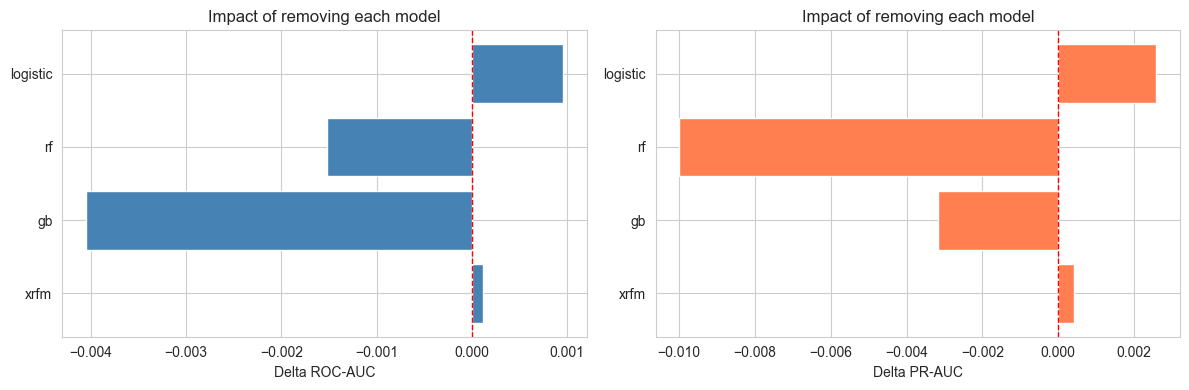

In [25]:
# Visualize deltas
df_plot = df_ablation[df_ablation["removed"] != "none"].copy()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# ROC AUC delta
axes[0].barh(df_plot["removed"], df_plot["delta_roc_auc"], color="steelblue")
axes[0].axvline(0, color="red", linestyle="--", linewidth=1)
axes[0].set_xlabel("Delta ROC-AUC")
axes[0].set_title("Impact of removing each model")
axes[0].invert_yaxis()

# PR AUC delta
axes[1].barh(df_plot["removed"], df_plot["delta_pr_auc"], color="coral")
axes[1].axvline(0, color="red", linestyle="--", linewidth=1)
axes[1].set_xlabel("Delta PR-AUC")
axes[1].set_title("Impact of removing each model")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## 2. Meta-model coefficients

Check what weights the logistic regression meta-learner assigns to each base model.

In [26]:
# Use meta_model from ablation (no retraining)
coefficients = full_meta_model.coef_[0]
intercept = full_meta_model.intercept_[0]

df_coef = pd.DataFrame({
    "model": list(base_models.keys()),
    "coefficient": coefficients
})

print(f"Intercept: {intercept:.4f}\n")
df_coef

Intercept: -3.3774



,model,coefficient
0,logistic,0.573558
1,rf,2.332980
2,gb,2.314686
3,xrfm,-0.057234


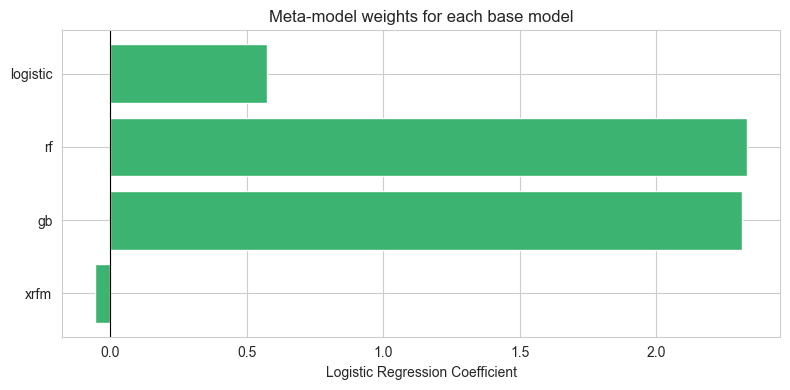

In [23]:
plt.figure(figsize=(8, 4))
plt.barh(df_coef["model"], df_coef["coefficient"], color="mediumseagreen")
plt.axvline(0, color="black", linestyle="-", linewidth=0.8)
plt.xlabel("Logistic Regression Coefficient")
plt.title("Meta-model weights for each base model")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()